# DQN vs Double DQN and DQN vs Multistep DQN

This notebook implements and compares:
- Vanilla DQN
- Double DQN 
- Multi-step DQN 


In [1]:
# Install dependencies
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install pandas

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple
import itertools

## Network Architecture

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

## Epsilon-Greedy Policy

In [4]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action.
    """
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()

    return policy_fn

## Epsilon Decay Schedule

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps).

    :returns: The current epsilon.
    """
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

## Replay Buffer

In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor, n_steps: torch.Tensor):
        """
        Adds a new transition to the buffer.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated, n_steps))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated, n_steps)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

## n-step Buffer

In [7]:
class nStepBuffer:
    def __init__(self, n: int, gamma: float):
        """
        Create the n-step buffer.

        :param n: The number of steps to look ahead.
        """
        self.data = []
        self.n = n
        self.gamma = gamma
        self.position = 0
        self.first_n = 0

    def reset(self):
        self.data = []
        self.position = 0
        self.first_n = 0  # Should be the only attribute thats not reset anyway
        
    def update(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer.
        """
        if self.first_n < self.n:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % (self.n if (self.first_n < self.n and not terminated) else len(self.data))

        if self.first_n < self.n and not terminated:
            self.first_n += 1
            return None, None, None, None, None, None
        else:
            R = torch.tensor(0.0)
            for k in range(len(self.data)):
                R = R + (self.gamma ** k) * self.data[(self.position + k) % len(self.data)][2]
            
            obs_t = self.data[self.position][0]
            action_t = self.data[self.position][1]
            next_obs_t = self.data[(self.position - 1) % len(self.data)][3]
            terminated_t = self.data[(self.position - 1) % len(self.data)][4]
            n_transitions = len(self.data)

            if terminated:
                if self.first_n < self.n:
                    self.first_n = self.n
                del self.data[(self.position - 1) % len(self.data)]
                self.position = (self.position - 1) % len(self.data) if self.position > 0 else 0

            return obs_t, action_t, R, next_obs_t, terminated_t, n_transitions

## Update Functions

### Vanilla DQN Update

In [8]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        n_steps: torch.Tensor,
    ):
    """
    Update the vanilla DQN.
    Uses the target network to both select and evaluate actions.
    Supports n-step returns via the n_steps input.
    """
    optimizer.zero_grad()

    # Vanilla DQN: Use target network to select AND evaluate
    with torch.no_grad():
        discount = torch.pow(torch.tensor(gamma, device=rew.device), n_steps.float())
        td_target = rew + discount * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # Calculate loss
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # Backpropagate
    loss.backward()
    optimizer.step()
    
    return loss.item()

### Double DQN Update

The key innovation: Use the online network to **select** the best action, but use the target network to **evaluate** it.

In [9]:
def update_double_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        n_steps: torch.Tensor,
    ):
    """
    Update the DQN network using Double DQN.
    Uses the online network to select actions, but target network to evaluate them.
    """
    optimizer.zero_grad()

    # Double DQN: Use online network to SELECT action, target network to EVALUATE
    with torch.no_grad():
        # Select best action using online network
        best_actions = q(next_obs).argmax(dim=1)
        # Evaluate selected action using target network
        next_q_values = q_target(next_obs).gather(1, best_actions.unsqueeze(1)).squeeze(1)
        discount = torch.pow(torch.tensor(gamma, device=rew.device), n_steps.float())
        td_target = rew + discount * next_q_values * (1 - tm.float())

    # Calculate loss
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # Backpropagate
    loss.backward()
    optimizer.step()
    
    return loss.item()

## Agent Classes

In [10]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards", "losses"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            n_steps=1,
            use_double_dqn=False,
        ):
        """
        Initialize the DQN agent.
        
        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        :param use_double_dqn: If True, use Double DQN update rule
        """
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.n_steps = n_steps
        self.n_transitions = 1
        self.use_double_dqn = use_double_dqn

        self.buffer = ReplayBuffer(maxlen)
        self.nstep_buffer = nStepBuffer(n=n_steps, gamma=gamma)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            losses=[],
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        agent_type = "Double DQN" if self.use_double_dqn else "Vanilla DQN"

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'{agent_type} - Episode {i_episode + 1}/{num_episodes}  '
                      f'Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  '
                      f'Avg Reward: {np.mean(stats.episode_rewards[max(0, i_episode-99):i_episode+1]):.2f}')

            self.nstep_buffer.reset()
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_lengths[i_episode] += 1
                stats.episode_rewards[i_episode] += reward
                
                # Store in n-step buffer and get "ready" transition from there
                if self.n_steps > 1:
                    obs_t, action_t, reward_t, next_obs, terminated, n_transitions = self.nstep_buffer.update(obs, action, reward, next_obs, terminated)
                else:
                    obs_t = obs
                    action_t = action
                    reward_t = reward
                    n_transitions = self.n_transitions

                # Skip if n-step buffer is not ready yet
                if obs_t is not None:

                    self.buffer.store(
                        torch.as_tensor(obs_t, dtype=torch.float32),
                        torch.as_tensor(action_t),
                        torch.as_tensor(reward_t, dtype=torch.float32),
                        torch.as_tensor(next_obs, dtype=torch.float32),
                        torch.as_tensor(terminated),
                        torch.as_tensor(n_transitions)
                    )

                    if len(self.buffer) >= self.batch_size:
                        obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, n_steps_batch = self.buffer.sample(self.batch_size)
                        
                        # Choose update function based on algorithm
                        if self.use_double_dqn:
                            loss = update_double_dqn(
                                self.q, self.q_target, self.optimizer, self.gamma,
                                obs_batch.float(), act_batch, rew_batch.float(),
                                next_obs_batch.float(), tm_batch, n_steps_batch
                            )
                        else:
                            loss = update_dqn(
                                self.q, self.q_target, self.optimizer, self.gamma,
                                obs_batch.float(), act_batch, rew_batch.float(),
                                next_obs_batch.float(), tm_batch, n_steps_batch
                            )
                        
                        stats.losses.append(loss)

                    if current_timestep % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())
                        
                    current_timestep += 1

                    if terminated or truncated or episode_time >= 500:
                        # Handle pending n-step transitions
                        while n_transitions > 1:
                            obs_t, action_t, reward_t, next_obs, terminated, n_transitions = self.nstep_buffer.update(obs, action, reward, next_obs, terminated)

                            self.buffer.store(
                                torch.as_tensor(obs_t, dtype=torch.float32),
                                torch.as_tensor(action_t),
                                torch.as_tensor(reward_t, dtype=torch.float32),
                                torch.as_tensor(next_obs, dtype=torch.float32),
                                torch.as_tensor(terminated),
                                torch.as_tensor(n_transitions)
                            )
                        break
                        
                    obs = next_obs
                
        return stats

## Training



In [11]:
# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters
LR = 0.00025
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 1000
EPS_START = 1.0
EPS_END = 0.01
SCHEDULE_DURATION = 100_000
NUM_EPISODES = 3_000
DISCOUNT_FACTOR = 0.99

# Create environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)



In [12]:
# Train Vanilla DQN
print("TRAINING VANILLA DQN")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

vanilla_agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    use_double_dqn=False,
)
vanilla_stats = vanilla_agent.train(NUM_EPISODES)

TRAINING VANILLA DQN
Vanilla DQN - Episode 100/3000  Time Step: 1126  Epsilon: 0.989  Avg Reward: 0.52
Vanilla DQN - Episode 200/3000  Time Step: 2180  Epsilon: 0.978  Avg Reward: 0.45
Vanilla DQN - Episode 300/3000  Time Step: 3154  Epsilon: 0.969  Avg Reward: 0.35
Vanilla DQN - Episode 400/3000  Time Step: 4114  Epsilon: 0.959  Avg Reward: 0.34
Vanilla DQN - Episode 500/3000  Time Step: 5048  Epsilon: 0.950  Avg Reward: 0.32
Vanilla DQN - Episode 600/3000  Time Step: 6014  Epsilon: 0.940  Avg Reward: 0.36
Vanilla DQN - Episode 700/3000  Time Step: 7072  Epsilon: 0.930  Avg Reward: 0.45
Vanilla DQN - Episode 800/3000  Time Step: 8054  Epsilon: 0.920  Avg Reward: 0.37
Vanilla DQN - Episode 900/3000  Time Step: 9208  Epsilon: 0.909  Avg Reward: 0.54
Vanilla DQN - Episode 1000/3000  Time Step: 10246  Epsilon: 0.899  Avg Reward: 0.43
Vanilla DQN - Episode 1100/3000  Time Step: 11326  Epsilon: 0.888  Avg Reward: 0.47
Vanilla DQN - Episode 1200/3000  Time Step: 12480  Epsilon: 0.876  Avg Re

In [48]:
# Train multi-step DQN
print("TRAINING MULTISTEP DQN")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

multistep_agent = DQNAgent(
    env, 
    gamma=0.99,
    lr=0.00025, 
    batch_size=32,
    eps_start=1.0, 
    eps_end=0.01,
    schedule_duration=100_000,  
    update_freq=1000,
    maxlen=100_000,
    n_steps=10,
    use_double_dqn=False
)
multistep_stats = multistep_agent.train(3000)

TRAINING MULTISTEP DQN
Vanilla DQN - Episode 100/3000  Time Step: 395  Epsilon: 0.996  Avg Reward: 0.45
Vanilla DQN - Episode 200/3000  Time Step: 674  Epsilon: 0.993  Avg Reward: 0.29
Vanilla DQN - Episode 300/3000  Time Step: 1024  Epsilon: 0.990  Avg Reward: 0.38
Vanilla DQN - Episode 400/3000  Time Step: 1333  Epsilon: 0.987  Avg Reward: 0.36
Vanilla DQN - Episode 500/3000  Time Step: 1627  Epsilon: 0.984  Avg Reward: 0.35
Vanilla DQN - Episode 600/3000  Time Step: 1933  Epsilon: 0.981  Avg Reward: 0.34
Vanilla DQN - Episode 700/3000  Time Step: 2247  Epsilon: 0.978  Avg Reward: 0.38
Vanilla DQN - Episode 800/3000  Time Step: 2731  Epsilon: 0.973  Avg Reward: 0.57
Vanilla DQN - Episode 900/3000  Time Step: 3082  Epsilon: 0.969  Avg Reward: 0.43
Vanilla DQN - Episode 1000/3000  Time Step: 3367  Epsilon: 0.967  Avg Reward: 0.33
Vanilla DQN - Episode 1100/3000  Time Step: 3724  Epsilon: 0.963  Avg Reward: 0.38
Vanilla DQN - Episode 1200/3000  Time Step: 4059  Epsilon: 0.960  Avg Rewar

In [13]:
# Train Double DQN

print("TRAINING DOUBLE DQN")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

double_agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR, 
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    use_double_dqn=True,
)
double_stats = double_agent.train(NUM_EPISODES)

TRAINING DOUBLE DQN
Double DQN - Episode 100/3000  Time Step: 938  Epsilon: 0.991  Avg Reward: 0.34
Double DQN - Episode 200/3000  Time Step: 1976  Epsilon: 0.980  Avg Reward: 0.43
Double DQN - Episode 300/3000  Time Step: 2994  Epsilon: 0.970  Avg Reward: 0.41
Double DQN - Episode 400/3000  Time Step: 4064  Epsilon: 0.960  Avg Reward: 0.45
Double DQN - Episode 500/3000  Time Step: 5138  Epsilon: 0.949  Avg Reward: 0.45
Double DQN - Episode 600/3000  Time Step: 6134  Epsilon: 0.939  Avg Reward: 0.38
Double DQN - Episode 700/3000  Time Step: 7270  Epsilon: 0.928  Avg Reward: 0.52
Double DQN - Episode 800/3000  Time Step: 8422  Epsilon: 0.917  Avg Reward: 0.54
Double DQN - Episode 900/3000  Time Step: 9394  Epsilon: 0.907  Avg Reward: 0.36
Double DQN - Episode 1000/3000  Time Step: 10364  Epsilon: 0.897  Avg Reward: 0.36
Double DQN - Episode 1100/3000  Time Step: 11512  Epsilon: 0.886  Avg Reward: 0.53
Double DQN - Episode 1200/3000  Time Step: 12570  Epsilon: 0.876  Avg Reward: 0.45
Dou

## Results Comparison



Vanilla DQN Gameplay:


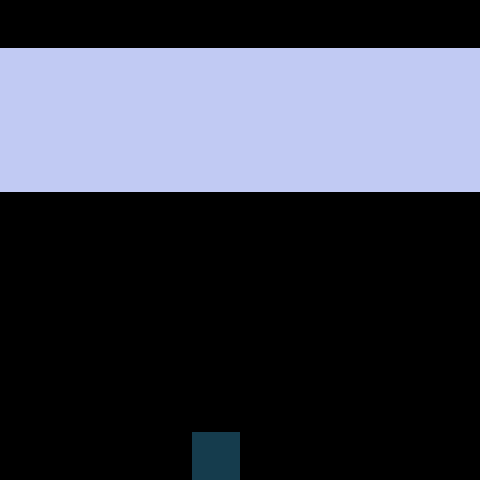


Double DQN Gameplay:


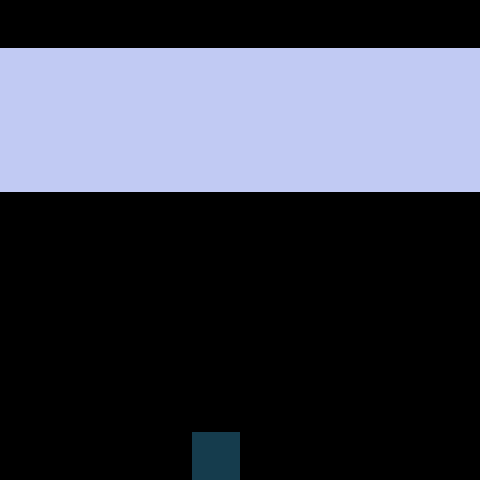

In [42]:
from IPython.display import Image as IImage
from PIL import Image

def save_rgb_animation(rgb_arrays, filename, duration=100):
    """Save an animated GIF from a list of RGB arrays."""
    frames = []
    
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array * 255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]
    
    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break
    
    return imgs

# Generate videos 

vanilla_policy = make_epsilon_greedy_policy(vanilla_agent.q, num_actions=env.action_space.n)
vanilla_imgs = rendered_rollout(vanilla_policy, env)
save_rgb_animation(vanilla_imgs, "Fvanilla_dqn_trained.gif")


double_policy = make_epsilon_greedy_policy(double_agent.q, num_actions=env.action_space.n)
double_imgs = rendered_rollout(double_policy, env)
save_rgb_animation(double_imgs, "Fdouble_dqn_trained.gif")

# Display both
print("\nVanilla DQN Gameplay:")
display(IImage(filename="Fvanilla_dqn_trained.gif"))

print("\nDouble DQN Gameplay:")
display(IImage(filename="Fdouble_dqn_trained.gif"))

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple


# EVALUATION: Test Trained Agents

def evaluate_agent(agent, env, num_episodes=100, seed=42):
    """
    Evaluate a trained agent over multiple episodes.
    Returns: list of episode rewards
    """
    policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
    rewards = []
    
    for i in range(num_episodes):
        obs, _ = env.reset(seed=seed + i)  # Reproducible episodes
        total_reward = 0
        
        for step in range(1000):  # Max steps per episode
            # Greedy policy (no exploration during evaluation)
            action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0), epsilon=0.0)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            
            if terminated or truncated:
                break   
        rewards.append(total_reward)
    return rewards

# PLOTTING FUNCTIONS 

def smooth_data(data: np.ndarray, window: int) -> pd.Series:
    # smoothen data using rolling mean
    return pd.Series(data).rolling(window, min_periods=window).mean()


def plot_episode_rewards(ax: plt.Axes, agents_stats: Dict[str, any], smoothing_window: int = 20):
    # Plot smoothed episode rewards for all extensions

    
    for i, (name, stats) in enumerate(agents_stats.items()):
        smoothed = smooth_data(stats.episode_rewards, smoothing_window)
        ax.plot(smoothed, label=name, linewidth=2, alpha=0.9)
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Episode Reward (Smoothed)', fontsize=12)
    ax.set_title(f'Episode Rewards Over Time (smoothed over {smoothing_window} episodes)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

def plot_moving_average_rewards(ax: plt.Axes, agents_stats: Dict[str, any], window: int = 100):

    # Plot moving average of episode rewards.
    for i, (name, stats) in enumerate(agents_stats.items()):
        cumulative = pd.Series(stats.episode_rewards).rolling(window, min_periods=1).mean()
        ax.plot(cumulative, label=name, linewidth=2, alpha=0.9)
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel(f'Average Reward (Last {window} episodes)', fontsize=12)
    ax.set_title('Moving Average of Episode Rewards', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)


def create_comparison_plot(
    agents_stats: Dict[str, any],
    title: str = "DQN Variants Comparison",
    smoothing_window: int = 20,
    loss_smoothing: int = 100,
    moving_avg_window: int = 100,
    save_path: str = None,
    figsize: Tuple[int, int] = (15, 10)
):
    """
    Comparison plot for multiple extensions
    
    Example usage:
        agents = {
            "Vanilla DQN": vanilla_stats,
            "Double DQN": double_stats,
            "Dueling DQN": dueling_stats
        }
        create_comparison_plot(agents, title="DQN Extensions Comparison")
    """

    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Plot 1: Episode Rewards
    plot_episode_rewards(axes[0], agents_stats, smoothing_window)
    
    # Plot 2: Moving Average Rewards
    plot_moving_average_rewards(axes[1], agents_stats, moving_avg_window)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def print_performance_summary(agents_stats: Dict[str, any], test_results: Dict[str, List[float]] = None, last_n_episodes: int = 100):
    # Print a comprehensive performance summary table.

    print("PERFORMANCE SUMMARY")

    # Training Performance
    print(f"\nTraining Performance (Last {last_n_episodes} Episodes):")
    print(f"{'Agent':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    for name, stats in agents_stats.items():
        last_rewards = stats.episode_rewards[-last_n_episodes:]
        print(f"{name:<30} {np.mean(last_rewards):>10.2f} {np.std(last_rewards):>10.2f} "
              f"{np.min(last_rewards):>10.2f} {np.max(last_rewards):>10.2f}")
    
    # Test Performance 
    if test_results:
        print(f"\n\nTest Performance:")
        print(f"{'Agent':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
        baseline_mean = None
        for name, rewards in test_results.items():
            mean_reward = np.mean(rewards)
            if baseline_mean is None:
                baseline_mean = mean_reward
            
            improvement = ((mean_reward - baseline_mean) / baseline_mean * 100) if baseline_mean > 0 else 0
            
            print(f"{name:<30} {mean_reward:>10.2f} {np.std(rewards):>10.2f} "
                  f"{np.min(rewards):>10.2f} {np.max(rewards):>10.2f}", end="")
            
            if name != list(test_results.keys())[0]: 
                print(f"  ({improvement:+.1f}%)", end="")
            print()


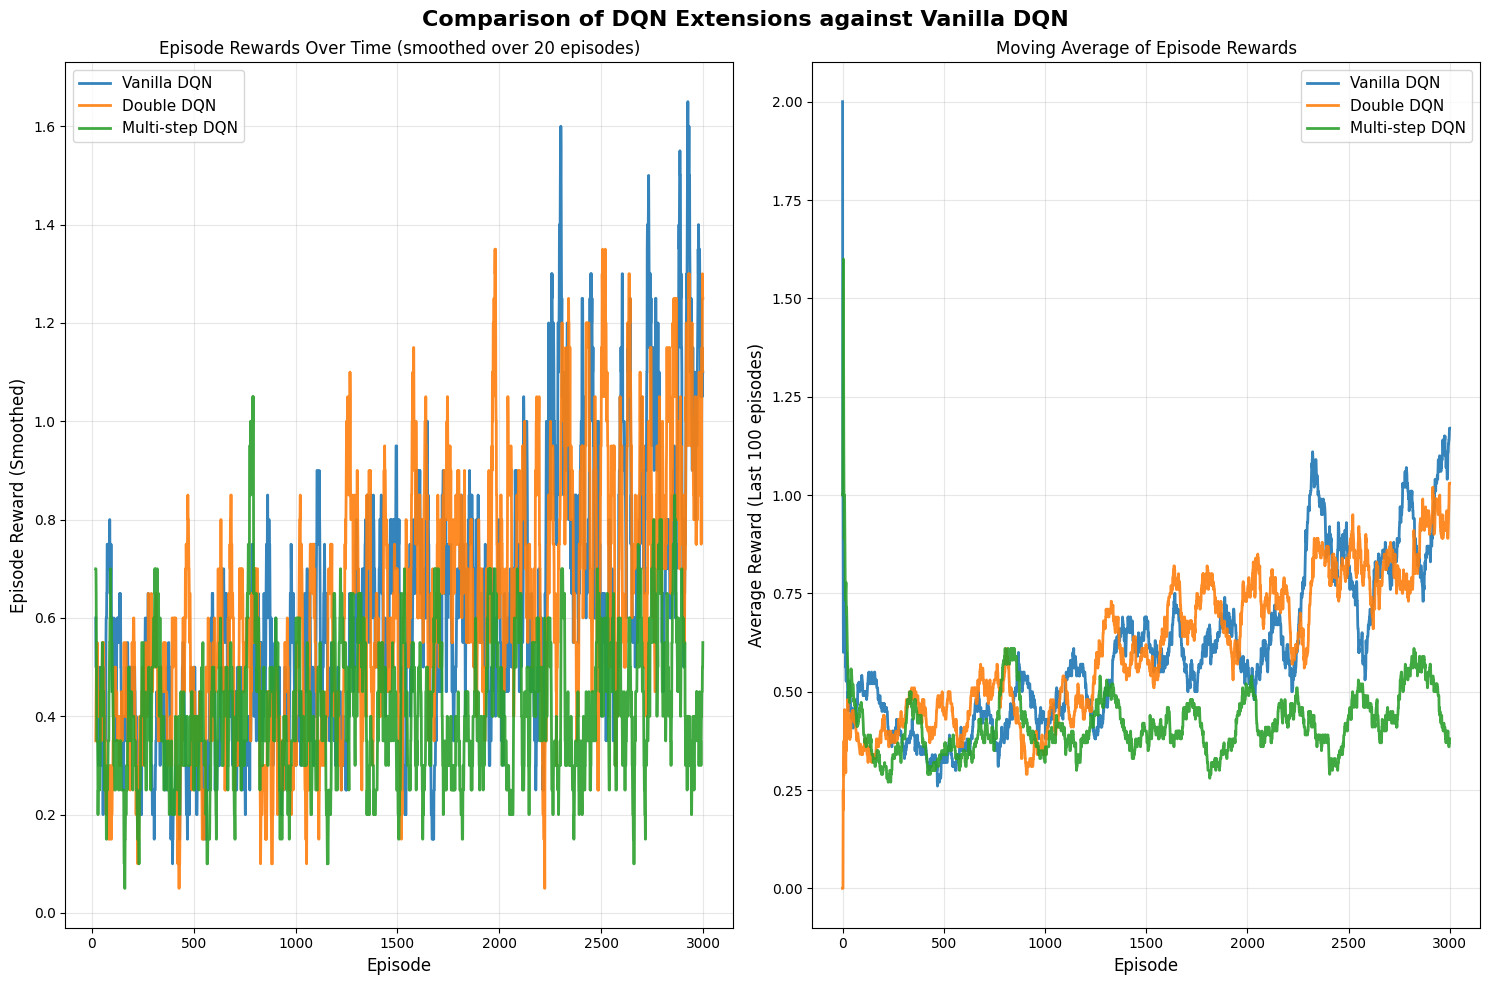

In [50]:
# After training your extensions
agents_stats = {
    "Vanilla DQN": vanilla_stats,
    "Double DQN": double_stats,
    "Multi-step DQN": multistep_stats,
}

# creates both the plots and saves to file
create_comparison_plot(
    agents_stats,
    title="Comparison of DQN Extensions against Vanilla DQN",
    save_path="results/comparison.png"
)

In [51]:
# Evaluate the extensions
vanilla_test_rewards = evaluate_agent(vanilla_agent, env, 100, SEED)
double_test_rewards = evaluate_agent(double_agent, env, 100, SEED)
multistep_test_rewards = evaluate_agent(multistep_agent, env, 100, SEED)

test_results = {
    "Vanilla DQN": vanilla_test_rewards,
    "Double DQN": double_test_rewards,
    "Multi-step DQN": multistep_test_rewards,
}

print_performance_summary(agents_stats, test_results)

PERFORMANCE SUMMARY

Training Performance (Last 100 Episodes):
Agent                                Mean        Std        Min        Max
Vanilla DQN                          1.17       1.20       0.00       5.00
Double DQN                           1.03       1.19       0.00       5.00
Multi-step DQN                       0.38       0.58       0.00       2.00


Test Performance:
Agent                                Mean        Std        Min        Max
Vanilla DQN                          3.79       2.08       0.00       9.00
Double DQN                           3.78       1.63       0.00       7.00  (-0.3%)
Multi-step DQN                       2.61       1.18       0.00       5.00  (-31.1%)


**SOME DRAFTS IDK**

In [46]:
# Check what the agent learned
print("=== Double DQN Agent Analysis ===\n")

# Check final epsilon value
print(f"Final epsilon reached: {linear_epsilon_decay(EPS_START, EPS_END, SCHEDULE_DURATION, SCHEDULE_DURATION):.4f}")

# Analyze Q-values
with torch.no_grad():
    # Sample some states from replay buffer (unpack the result - first element are the states)
    if len(double_agent.buffer) > 0:
        sample_states, _, _, _, _, _ = double_agent.buffer.sample(min(32, len(double_agent.buffer)))
        q_values = double_agent.q(sample_states.float())
        
        print(f"\nQ-value statistics from sampled states:")
        print(f"  Mean Q-value: {q_values.mean().item():.4f}")
        print(f"  Std Q-value: {q_values.std().item():.4f}")
        print(f"  Max Q-value: {q_values.max().item():.4f}")
        print(f"  Min Q-value: {q_values.min().item():.4f}")
        print(f"  Q-value range per state (avg): {(q_values.max(dim=1)[0] - q_values.min(dim=1)[0]).mean().item():.4f}")

# Check action distribution in replay buffer
if len(double_agent.buffer) > 0:
    _, actions, _, _, _, _ = double_agent.buffer.sample(min(1000, len(double_agent.buffer)))
    actions = actions.long()  # ensure integer dtype for bincount
    action_counts = torch.bincount(actions, minlength=env.action_space.n)
    print(f"\nAction distribution in replay buffer:")
    for i, count in enumerate(action_counts):
        print(f"  Action {i}: {count.item()} ({count.item()/len(actions)*100:.1f}%)")

# Compare with vanilla DQN
print("\n=== Vanilla DQN Agent Analysis ===\n")
with torch.no_grad():
    if len(vanilla_agent.buffer) > 0:
        sample_states, _, _, _, _, _ = vanilla_agent.buffer.sample(min(32, len(vanilla_agent.buffer)))
        q_values = vanilla_agent.q(sample_states.float())
        
        print(f"Q-value statistics from sampled states:")
        print(f"  Mean Q-value: {q_values.mean().item():.4f}")
        print(f"  Std Q-value: {q_values.std().item():.4f}")
        print(f"  Max Q-value: {q_values.max().item():.4f}")
        print(f"  Min Q-value: {q_values.min().item():.4f}")
        print(f"  Q-value range per state (avg): {(q_values.max(dim=1)[0] - q_values.min(dim=1)[0]).mean().item():.4f}")

# Check action distribution in replay buffer
if len(vanilla_agent.buffer) > 0:
    _, actions, _, _, _, _ = vanilla_agent.buffer.sample(min(1000, len(vanilla_agent.buffer)))
    actions = actions.long()  # ensure integer dtype for bincount
    action_counts = torch.bincount(actions, minlength=env.action_space.n)
    print(f"\nAction distribution in replay buffer:")
    for i, count in enumerate(action_counts):
        print(f"  Action {i}: {count.item()} ({count.item()/len(actions)*100:.1f}%)")

=== Double DQN Agent Analysis ===

Final epsilon reached: 0.0100

Q-value statistics from sampled states:
  Mean Q-value: 1.9400
  Std Q-value: 1.0811
  Max Q-value: 3.4080
  Min Q-value: -0.1165
  Q-value range per state (avg): 0.5527

Action distribution in replay buffer:
  Action 0: 314 (31.4%)
  Action 1: 342 (34.2%)
  Action 2: 344 (34.4%)

=== Vanilla DQN Agent Analysis ===

Q-value statistics from sampled states:
  Mean Q-value: 2.2392
  Std Q-value: 1.5644
  Max Q-value: 4.2312
  Min Q-value: -0.2548
  Q-value range per state (avg): 0.8543

Action distribution in replay buffer:
  Action 0: 311 (31.1%)
  Action 1: 338 (33.8%)
  Action 2: 351 (35.1%)
